In [1]:
from pathlib import Path
import json
import math
import re

import matplotlib.pyplot as plt
import pandas as pd

def extract_model_suffix(model_name: str) -> str:
    """Extract the suffix from model name (e.g., 'clean', 'noisy20', 'noisy40', 'noisy48')."""
    # Pattern to match suffixes like clean, noisy20, noisy40, noisy48
    patterns = [
        r'noisy(\d+)',  # matches noisy20, noisy40, noisy48
        r'clean',       # matches clean
    ]
    
    for pattern in patterns:
        match = re.search(pattern, model_name, re.IGNORECASE)
        if match:
            if 'noisy' in pattern:
                return f"noisy{match.group(1)}"
            else:
                return "clean"
    
    return "unknown"

def plot_many(trainer_state_paths, checkpoint_num=None, smoothing=None, fields_to_plot=None):
    """
    Plot training metrics from trainer state files.
    
    Args:
        trainer_state_paths: Path(s) to trainer state files or directory containing models
        checkpoint_num: Specific checkpoint number to use (None = use latest)
        smoothing: Rolling window size for smoothing (None = no smoothing)
        fields_to_plot: List of field names to plot (None = plot all numeric fields)
    """
    if not isinstance(trainer_state_paths, (list, tuple)):
        base_path = Path(trainer_state_paths)
        if base_path.is_dir():
            trainer_state_paths = []
            for model_dir in base_path.iterdir():
                if not model_dir.is_dir():
                    continue
                checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
                if not checkpoints:
                    continue
                checkpoint_numbers = []
                for cp in checkpoints:
                    try:
                        num = int(cp.name.split("-")[1])
                        checkpoint_numbers.append((num, cp))
                    except (ValueError, IndexError):
                        continue
                if checkpoint_numbers:
                    if checkpoint_num is not None:
                        target_checkpoint = None
                        for num, cp in checkpoint_numbers:
                            if num == checkpoint_num:
                                target_checkpoint = cp
                                break
                        if target_checkpoint is None:
                            continue
                    else:
                        target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
                    trainer_state_file = target_checkpoint / "trainer_state.json"
                    if trainer_state_file.exists():
                        trainer_state_paths.append(trainer_state_file)
        else:
            trainer_state_paths = [base_path]
    
    if not trainer_state_paths:
        raise ValueError("No trainer state files found")
    
    all_log_dfs = []
    path_labels = []
    
    for trainer_state_path in trainer_state_paths:
        with trainer_state_path.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            raise ValueError(f"log_history is empty in {trainer_state_path}")
        
        log_df = pd.DataFrame(log_history)
        all_log_dfs.append(log_df)
        path_labels.append(trainer_state_path.parent.parent.name)
    
    if not all_log_dfs:
        raise ValueError("No valid trainer states found")
    
    display(all_log_dfs[0].head())
    
    value_cols = [
        col for col in all_log_dfs[0].columns
        if pd.api.types.is_numeric_dtype(all_log_dfs[0][col]) and col != "step"
    ]
    
    # Filter to only requested fields if specified
    if fields_to_plot is not None:
        available_fields = [col for col in fields_to_plot if col in value_cols]
        missing_fields = [col for col in fields_to_plot if col not in value_cols]
        if missing_fields:
            print(f"Warning: Fields not found: {missing_fields}")
        if not available_fields:
            raise ValueError(f"None of the requested fields {fields_to_plot} were found in the data")
        value_cols = available_fields
    
    num_plots = len(value_cols)
    n_cols = 2
    n_rows = math.ceil(num_plots / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3.25 * n_rows), squeeze=False)
    
    for ax, col in zip(axes.flat, value_cols):
        for log_df, label in zip(all_log_dfs, path_labels):
            x_values = log_df["step"] if "step" in log_df.columns else range(len(log_df))
            if col in log_df.columns:
                y_values = log_df[col]
                if smoothing is not None and smoothing > 1:
                    y_values = y_values.rolling(window=smoothing, center=True, min_periods=1).mean()
                ax.plot(x_values, y_values, linewidth=1.5, label=label)
        
        ax.set_title(col)
        ax.set_xlabel("step" if "step" in all_log_dfs[0].columns else "index")
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    for ax in axes.flat[num_plots:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

def group_models_by_suffix(base_path: Path, checkpoint_num=None):
    """Group model directories by their suffix (clean, noisy20, noisy40, noisy48)."""
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    groups = {}
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        suffix = extract_model_suffix(model_dir.name)
        if suffix not in groups:
            groups[suffix] = []
        groups[suffix].append(trainer_state_file)
    
    return groups



Found 4 groups: ['clean', 'noisy20', 'noisy40', 'noisy48']
  noisy48: 3 models
  noisy20: 4 models
  noisy40: 5 models
  clean: 4 models

Plotting group: clean


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.592187,0.01032,35.306362,0.000010,1.3858,0.618511,6.381467,0.868239,-5.038135,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.606250,0.02064,31.232433,0.000010,1.3700,1.140653,6.828486,-1.373284,-8.717750,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.629687,0.03096,76.178528,0.000010,1.3176,0.681849,6.954213,1.907392,-2.339943,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.667188,0.04128,34.948742,0.000010,1.2050,1.543756,8.479906,-0.239647,-8.110076,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.662500,0.05160,22.566885,0.000009,1.1809,1.647875,13.481833,5.988788,-4.855562,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


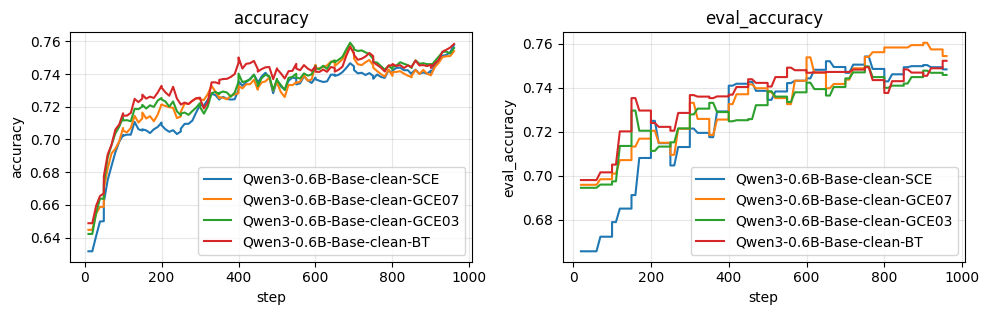


Plotting group: noisy20


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.570312,0.01032,7.442329,0.000010,0.5293,0.158503,5.904214,3.173551,-1.080381,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,7.998268,0.000010,0.5434,0.295973,7.051212,2.803451,-2.719099,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.625000,0.03096,6.547256,0.000010,0.4776,0.645610,6.329265,1.400977,-3.315802,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.618750,0.04128,5.947553,0.000010,0.4934,0.520184,6.897339,2.288440,-2.039699,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.584375,0.05160,4.356923,0.000009,0.5147,0.430439,6.357493,1.711673,-2.527280,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


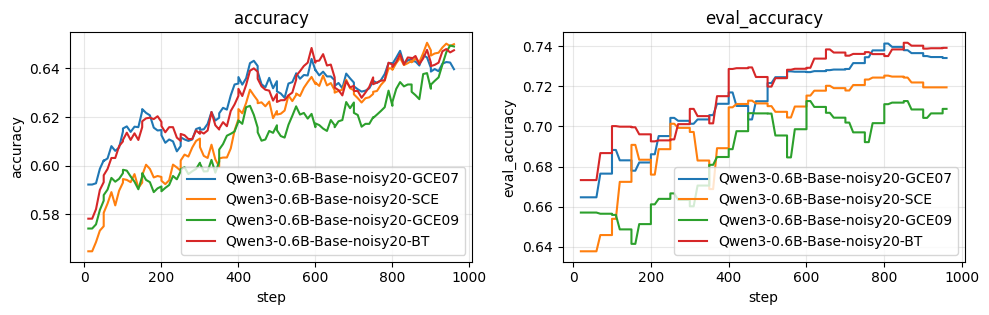


Plotting group: noisy40


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.492188,0.01032,5.213758,0.000010,0.7259,0.002485,5.326846,3.565464,1.687398,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.521875,0.02064,2.177735,0.000010,0.7064,-0.007228,4.235545,3.233110,2.101016,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.496875,0.03096,2.361068,0.000010,0.6935,0.010059,2.813201,1.854601,0.995472,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.492188,0.04128,1.410109,0.000010,0.6979,-0.002217,2.747095,1.861573,1.238248,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.520312,0.05160,1.405182,0.000009,0.6909,0.009434,1.626536,1.132094,0.530329,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


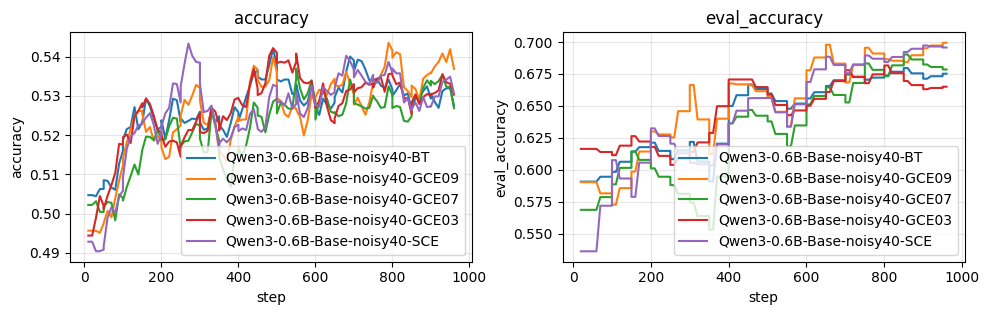


Plotting group: noisy48


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.525000,0.01032,7.500800,0.000010,0.5556,0.049746,4.555255,-0.340357,-3.113806,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.485938,0.02064,2.619746,0.000010,0.5805,-0.109715,10.558673,0.922915,-1.196203,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.498437,0.03096,2.022751,0.000010,0.5541,-0.009290,-0.003442,-1.310405,-2.298844,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.464062,0.04128,1.381833,0.000010,0.5575,-0.021838,1.234350,0.255949,-0.434748,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.478125,0.05160,1.555659,0.000009,0.5535,-0.010731,1.644073,0.982398,0.342574,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


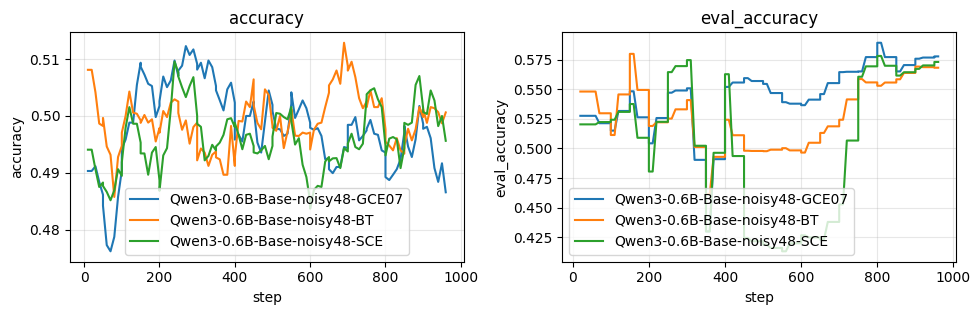

In [4]:
# Plot all groups separately, showing only accuracy and eval_accuracy
base_path = Path("models_final/")
groups = group_models_by_suffix(base_path)

print(f"Found {len(groups)} groups: {sorted(groups.keys())}")
for suffix, paths in groups.items():
    print(f"  {suffix}: {len(paths)} models")

# Plot each group separately
for suffix, trainer_state_paths in sorted(groups.items()):
    print(f"\nPlotting group: {suffix}")
    plot_many(trainer_state_paths, smoothing=10, fields_to_plot=["accuracy", "eval_accuracy"])

In [3]:
# values
from pathlib import Path
import json
import pandas as pd

def output_metrics(base_path, checkpoint_num=None, metrics_to_show=None):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    results = []
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        with trainer_state_file.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            continue
        
        log_df = pd.DataFrame(log_history)
        
        model_name = model_dir.name
        checkpoint_used = target_checkpoint.name
        
        # If filtering to specific metrics, find the last entry that has those metrics
        if metrics_to_show is not None:
            # Find entries that have at least one of the requested metrics
            available_cols = set(log_df.columns)
            requested_cols = set(metrics_to_show)
            missing_cols = requested_cols - available_cols
            if missing_cols:
                print(f"Warning: {model_name} - missing columns: {missing_cols}")
            
            # Find the last entry that has any of the requested metrics (non-NaN)
            last_entry = None
            if "step" in log_df.columns:
                # Sort by step descending and find first entry with requested metrics
                sorted_df = log_df.sort_values("step", ascending=False)
                for idx, row in sorted_df.iterrows():
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            else:
                # Check from the end backwards
                for idx in range(len(log_df) - 1, -1, -1):
                    row = log_df.iloc[idx]
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            
            if last_entry is None:
                # Fallback to last entry even if NaN
                if "step" in log_df.columns:
                    last_entry = log_df.loc[log_df["step"].idxmax()]
                else:
                    last_entry = log_df.iloc[-1]
        else:
            # Show all metrics - use last entry
            if "step" in log_df.columns:
                last_entry = log_df.loc[log_df["step"].idxmax()]
            else:
                last_entry = log_df.iloc[-1]
        
        metrics = {}
        for col in log_df.columns:
            if pd.api.types.is_numeric_dtype(log_df[col]) and col != "step":
                if metrics_to_show is None or col in metrics_to_show:
                    metrics[col] = last_entry[col]
        
        results.append({
            "model": model_name,
            **metrics
        })
    
    if not results:
        print("No results found")
        return
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("model")
    
    return results_df

display(output_metrics(Path("models_final/"), metrics_to_show=["eval_accuracy", "eval_margin"]))
display(output_metrics(Path("models_epoch3/"), metrics_to_show=["eval_accuracy", "eval_margin"]))


,model,eval_accuracy,eval_margin
13,Qwen3-0.6B-Base-clean-BT,0.752344,1.085453
11,Qwen3-0.6B-Base-clean-GCE03,0.745898,1.517395
9,Qwen3-0.6B-Base-clean-GCE07,0.754492,3.346831
7,Qwen3-0.6B-Base-clean-SCE,0.748438,3.571979
14,Qwen3-0.6B-Base-noisy20-BT,0.739258,0.418071
2,Qwen3-0.6B-Base-noisy20-GCE07,0.734180,1.705286
6,Qwen3-0.6B-Base-noisy20-GCE09,0.708789,4.827339
3,Qwen3-0.6B-Base-noisy20-SCE,0.719531,2.104979
4,Qwen3-0.6B-Base-noisy40-BT,0.675195,0.065464
12,Qwen3-0.6B-Base-noisy40-GCE03,0.665039,0.099759


,model,eval_accuracy,eval_margin
5,Qwen3-0.6B-Base-clean-BT,0.733789,12.129924
4,Qwen3-0.6B-Base-clean-GCE07,0.719531,9.906538
6,Qwen3-0.6B-Base-noisy20-BT,0.641992,5.416716
0,Qwen3-0.6B-Base-noisy20-GCE07,0.687695,6.485916
1,Qwen3-0.6B-Base-noisy20-SCE,0.669727,2.998012
2,Qwen3-0.6B-Base-noisy40-BT,0.575977,1.022830
3,Qwen3-0.6B-Base-noisy40-GCE09,0.624219,3.351973
